# Colab Setup

In [ ]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/diffusion_model_mix"
if not os.path.exists(datadir):
  !ln -s "/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/diffusion model mix/" $datadir # TODO: Fill your Assignment 4 path
os.chdir(datadir)
!pwd

/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/diffusion model mix


# Data Setup


## data download

In [ ]:
#
!unzip "/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/train.zip" -d "/content/data2"


串流輸出內容已截斷至最後 5000 行。
  inflating: /content/data2/train/e99750b4-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png  
  inflating: /content/data2/__MACOSX/train/._e99750b4-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png  
  inflating: /content/data2/train/8058dc12-bbc4-11e8-b2bc-ac1f6b6435d0_red.png  
  inflating: /content/data2/__MACOSX/train/._8058dc12-bbc4-11e8-b2bc-ac1f6b6435d0_red.png  
  inflating: /content/data2/train/edf9faa6-bbb7-11e8-b2ba-ac1f6b6435d0_red.png  
  inflating: /content/data2/__MACOSX/train/._edf9faa6-bbb7-11e8-b2ba-ac1f6b6435d0_red.png  
  inflating: /content/data2/train/f721d41e-bb9e-11e8-b2b9-ac1f6b6435d0_green.png  
  inflating: /content/data2/__MACOSX/train/._f721d41e-bb9e-11e8-b2b9-ac1f6b6435d0_green.png  
  inflating: /content/data2/train/3d9ef3aa-bbbc-11e8-b2ba-ac1f6b6435d0_blue.png  
  inflating: /content/data2/__MACOSX/train/._3d9ef3aa-bbbc-11e8-b2ba-ac1f6b6435d0_blue.png  
  inflating: /content/data2/train/e2774572-bbbb-11e8-b2ba-ac1f6b6435d0_red.png  
  inflating: /content

In [ ]:
!mkdir -p /content/diffusion/generated_images/
!cp -r "/content/diffusion_model_mix/generated_images/" /content/diffusion/generated_images/


## Dataloader

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.transforms.functional as F
from PIL import Image
# import pandas as pd
import os
import random

from PIL import Image


class CustomMultiLabelWithGeneratedDataset(Dataset):
    def __init__(self, csv_path, img_dir, gen_dir, transform=None, id_list=None):
        self.img_dir = img_dir
        self.gen_dir = gen_dir
        self.transform = transform
        self.colors = ['red', 'green', 'blue', 'yellow']

        df = pd.read_csv(csv_path)
        self.id2label = {row['Id']: row['Target'] for _, row in df.iterrows()}

        all_ids_in_csv = set(self.id2label.keys())
        all_files = os.listdir(img_dir)
        all_ids_on_disk = set(fname.split('_')[0] for fname in all_files if fname.endswith('_red.png'))
        valid_ids = sorted(all_ids_in_csv & all_ids_on_disk)

        self.available_ids = sorted(set(id_list) & set(valid_ids)) if id_list else valid_ids

        all_labels = set()
        for label_str in self.id2label.values():
            labels = map(int, label_str.split())
            all_labels.update(labels)
        self.label_map = {label: i for i, label in enumerate(sorted(all_labels))}
        self.num_classes = len(self.label_map)

        self.gen_paths = []
        self.gen_labels = []
        for class_id in range(self.num_classes):
            class_dir = os.path.join(self.gen_dir, f"class_{class_id}")
            gen_files = sorted([f for f in os.listdir(class_dir) if f.endswith(".png")])
            for fname in gen_files:
                self.gen_paths.append(os.path.join(class_dir, fname))
                self.gen_labels.append(class_id)

    def __len__(self):
        return len(self.available_ids)

    def __getitem__(self, idx):
        base_id = self.available_ids[idx]
        rotation_angle = random.choice([0, 90, 180, 270])
        channels = []
        for color in self.colors:
            path = os.path.join(self.img_dir, f"{base_id}_{color}.png")
            img = Image.open(path).convert('L').rotate(rotation_angle)
            channels.append(img)

        real_image = np.stack([np.array(ch) for ch in channels], axis=0)
        real_image = torch.from_numpy(real_image).float() / 255.0
        if self.transform:
            real_image = self.transform(real_image)

        real_label = torch.zeros(self.num_classes)
        for label in map(int, self.id2label[base_id].split()):
            real_label[self.label_map[label]] = 1

        gen_idx = random.randint(0, len(self.gen_paths) - 1)
        gen_img = Image.open(self.gen_paths[gen_idx]).convert('RGBA')  # 保留 4 channel
        gen_img = gen_img.resize((512, 512), resample=Image.BICUBIC)
        gen_img = np.array(gen_img).transpose(2, 0, 1)  # [C, H, W]
        gen_img = torch.from_numpy(gen_img).float() / 255.0
        if self.transform:
            gen_img = self.transform(gen_img)

        gen_label = torch.zeros(self.num_classes)
        gen_label[self.gen_labels[gen_idx]] = 1.0  # 單一 class

        return real_image, real_label, gen_img, gen_label


transform_train = transforms.Compose([
    transforms.RandomResizedCrop(512, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    # transforms.ToTensor()
])

transform_val = transforms.Compose([
    # transforms.ToTensor()
])




In [ ]:
import os
import random
from sklearn.model_selection import train_test_split
import pandas as pd
# import numpy as np

img_dir = '/content/data2/train'
gen_dir = '/content/diffusion/generated_images/generated_images'
all_files = os.listdir(img_dir)
all_ids = sorted(set(
    fname.split('_')[0]
    for fname in all_files if fname.endswith('_red.png')
))

# 切分 9:1
train_ids, val_ids = train_test_split(all_ids, test_size=0.1, random_state=42)

train_dataset = CustomMultiLabelWithGeneratedDataset(
    csv_path='/content/data2/train.csv',
    img_dir=img_dir,
    gen_dir=gen_dir,
    transform=transform_train,
    id_list=train_ids
)

val_dataset = CustomMultiLabelWithGeneratedDataset(
    csv_path='/content/data2/train.csv',
    img_dir=img_dir,
    gen_dir=gen_dir,
    transform=transform_val,
    id_list=val_ids
)

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

torch.Size([64, 28])


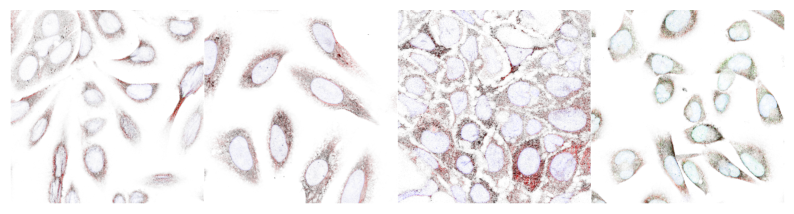

torch.Size([64, 28])


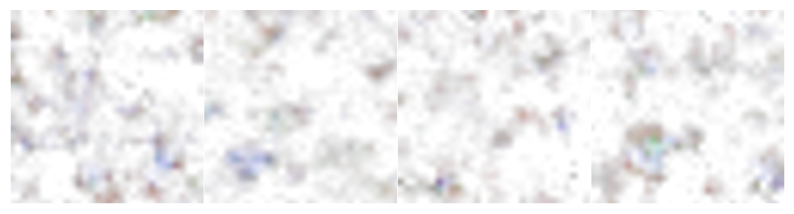

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

for images, labels, gen_img, gen_labels in train_loader:
    imgs = images[:4]
    grid = torchvision.utils.make_grid(imgs, nrow=4)
    print(labels.shape)
    plt.figure(figsize=(10, 3))
    npimg = grid.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # C, H, W → H, W, C
    plt.axis('off')
    plt.show()

    gen_imgs = gen_img[:4]
    gen_grid = torchvision.utils.make_grid(gen_imgs, nrow=4)
    print(gen_labels.shape)
    gen_npimg = gen_grid.numpy()

    plt.figure(figsize=(10, 3))
    plt.imshow(np.transpose(gen_npimg, (1, 2, 0)))  # C, H, W → H, W, C
    plt.axis('off')
    plt.show()

    break


# Model

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

def modify_first_conv(model, in_channels):
    old_conv = model.conv1
    new_conv = nn.Conv2d(in_channels, old_conv.out_channels,
                         kernel_size=old_conv.kernel_size,
                         stride=old_conv.stride,
                         padding=old_conv.padding,
                         bias=old_conv.bias is not None)

    # Copy weights from the first 3 channels
    with torch.no_grad():
        new_conv.weight[:, :3] = old_conv.weight
        if in_channels > 3:
            # Initialize extra channel(s) with zeros
            new_conv.weight[:, 3:] = old_conv.weight[:, :1].mean(dim=1, keepdim=True)

    model.conv1 = new_conv
    return model

In [ ]:
class MixedSupervisionModel(nn.Module):
    def __init__(self, num_classes=28, backbone_type='resnet18', beta_param=1.0, in_channels=4):
        super().__init__()
        self.beta_param = beta_param

        # Load and modify backbone
        if backbone_type == 'resnet18':
            backbone = models.resnet18(pretrained=True)
        elif backbone_type == 'resnet34':
            backbone = models.resnet34(pretrained=True)
        else:
            raise ValueError("backbone_type must be 'resnet18' or 'resnet34'")

        backbone = modify_first_conv(backbone, in_channels=in_channels)
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])  # remove FC
        self.feature_dim = backbone.fc.in_features

        self.classifier = nn.Linear(self.feature_dim, num_classes)
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, img_real, label_real, img_gen=None, label_gen=None):
        feat_real = self.backbone(img_real).squeeze(-1).squeeze(-1)

        if img_gen is not None and label_gen is not None:
            batch_size = img_real.size(0)

            # Sample mix ratio
            lam = torch.distributions.Beta(self.beta_param, self.beta_param).sample((batch_size,)).to(img_real.device)
            lam = lam.view(-1, 1)

            feat_gen = self.backbone(img_gen).squeeze(-1).squeeze(-1)

            # Mix features and labels
            mixed_feat = lam * feat_real + (1 - lam) * feat_gen
            mixed_label = lam * label_real + (1 - lam) * label_gen
        else:
            mixed_feat = feat_real
            mixed_label = label_real

        # Classification
        logits = self.classifier(mixed_feat)
        loss = self.criterion(logits, mixed_label)
        return loss, logits

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from tqdm import tqdm

def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler=None,
    num_epochs=10,
    device='cuda',
    base_lr=1e-4,
    warmup_epochs = 10,
    early_stop_patience = 5
):
    model.to(device)

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_f1': [],
    }

    best_f1 = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for real_img, real_label, gen_img, gen_label in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            real_img = real_img.to(device)
            real_label = real_label.to(device)
            gen_img = gen_img.to(device)
            gen_label = gen_label.to(device)

            optimizer.zero_grad()
            loss, _ = model(real_img, real_label, gen_img, gen_label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # ===== Validation =====
        model.eval()
        val_loss = 0.0
        preds_all = []
        labels_all = []

        with torch.no_grad():
            for real_img, real_label, _, _ in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                real_img = real_img.to(device)
                real_label = real_label.to(device)

                loss, logits = model(real_img, real_label)
                val_loss += loss.item()

                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).int().cpu().numpy()
                labels = real_label.cpu().numpy()

                preds_all.append(preds)
                labels_all.append(labels)

        avg_val_loss = val_loss / len(val_loader)

        preds_all = np.concatenate(preds_all, axis=0)
        labels_all = np.concatenate(labels_all, axis=0)
        val_f1 = f1_score(labels_all, preds_all, average='macro')

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_f1'].append(val_f1)

        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val F1 (macro): {val_f1:.4f}")

        if scheduler is not None:
            if epoch < warmup_epochs:
                for g in optimizer.param_groups:
                    g['lr'] = base_lr * (epoch + 1) / warmup_epochs
            else:
                scheduler.step(val_f1)

        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print(f"Early stopping at epoch {epoch+1} due to no improvement in val F1.")
                break

    # ===== Plotting =====
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['val_f1'], label='Val Macro F1', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Validation Macro F1')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
model = MixedSupervisionModel(
    num_classes=28,
    backbone_type='resnet18',
    beta_param=0.3,
    in_channels=4
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

Epoch 1/100 [Val]: 100%|██████████| 49/49 [00:42<00:00,  1.15it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 1] Train Loss: 0.1742 | Val Loss: 0.1611 | Val F1 (macro): 0.1371


Epoch 2/100 [Val]: 100%|██████████| 49/49 [00:42<00:00,  1.14it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 2] Train Loss: 0.1135 | Val Loss: 0.1500 | Val F1 (macro): 0.1628


Epoch 3/100 [Val]: 100%|██████████| 49/49 [00:42<00:00,  1.16it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 3] Train Loss: 0.1073 | Val Loss: 0.1421 | Val F1 (macro): 0.2036


Epoch 4/100 [Val]: 100%|██████████| 49/49 [00:41<00:00,  1.18it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 4] Train Loss: 0.1012 | Val Loss: 0.1468 | Val F1 (macro): 0.2192


Epoch 5/100 [Val]: 100%|██████████| 49/49 [00:41<00:00,  1.19it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 5] Train Loss: 0.0959 | Val Loss: 0.1358 | Val F1 (macro): 0.2486


Epoch 6/100 [Val]: 100%|██████████| 49/49 [00:41<00:00,  1.18it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 6] Train Loss: 0.0907 | Val Loss: 0.1221 | Val F1 (macro): 0.3010


Epoch 7/100 [Val]: 100%|██████████| 49/49 [00:41<00:00,  1.18it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 7] Train Loss: 0.0869 | Val Loss: 0.1268 | Val F1 (macro): 0.3260


Epoch 8/100 [Val]: 100%|██████████| 49/49 [00:41<00:00,  1.17it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 8] Train Loss: 0.0845 | Val Loss: 0.1234 | Val F1 (macro): 0.3149


Epoch 9/100 [Val]: 100%|██████████| 49/49 [00:41<00:00,  1.18it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 9] Train Loss: 0.0811 | Val Loss: 0.1240 | Val F1 (macro): 0.3220


Epoch 10/100 [Val]: 100%|██████████| 49/49 [00:41<00:00,  1.19it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 10] Train Loss: 0.0795 | Val Loss: 0.1317 | Val F1 (macro): 0.3224


Epoch 11/100 [Val]: 100%|██████████| 49/49 [00:41<00:00,  1.19it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 11] Train Loss: 0.0768 | Val Loss: 0.1369 | Val F1 (macro): 0.2906


Epoch 12/100 [Val]: 100%|██████████| 49/49 [00:41<00:00,  1.17it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 12] Train Loss: 0.0748 | Val Loss: 0.1336 | Val F1 (macro): 0.3393


Epoch 13/100 [Val]: 100%|██████████| 49/49 [00:41<00:00,  1.18it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 13] Train Loss: 0.0735 | Val Loss: 0.1448 | Val F1 (macro): 0.3163


Epoch 14/100 [Val]: 100%|██████████| 49/49 [00:41<00:00,  1.18it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 14] Train Loss: 0.0717 | Val Loss: 0.1643 | Val F1 (macro): 0.2761


Epoch 15/100 [Val]: 100%|██████████| 49/49 [00:41<00:00,  1.19it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 15] Train Loss: 0.0705 | Val Loss: 0.1503 | Val F1 (macro): 0.3113


Epoch 16/100 [Val]: 100%|██████████| 49/49 [00:41<00:00,  1.18it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 16] Train Loss: 0.0700 | Val Loss: 0.1511 | Val F1 (macro): 0.3118


Epoch 17/100 [Val]: 100%|██████████| 49/49 [00:41<00:00,  1.17it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 17] Train Loss: 0.0690 | Val Loss: 0.1424 | Val F1 (macro): 0.3250
Early stopping at epoch 17 due to no improvement in val F1.


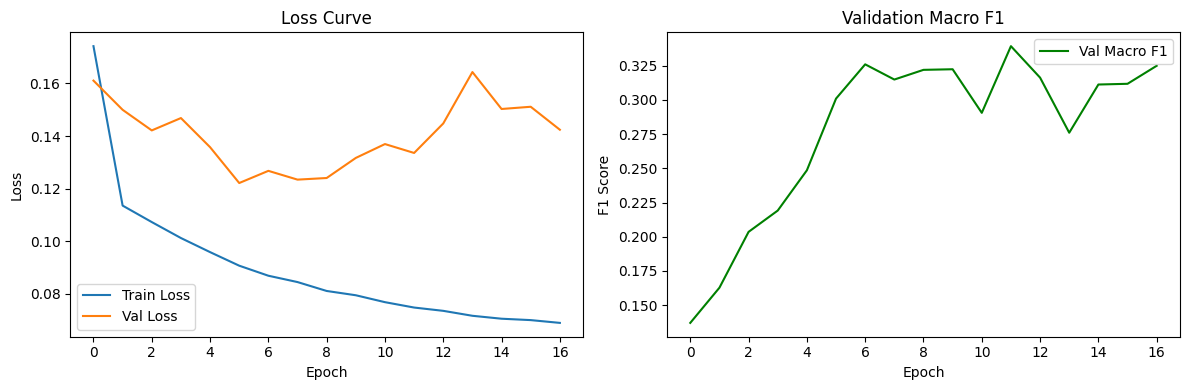

In [ ]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=100,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)


In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'epoch': 100
}, f"/content/diffusion_model_mix/mixModel_18.pth")